In [1]:
import os
import cv2 
import numpy as np


In [2]:
def list_images(basePath, validExts=(".jpg", ".jpeg"), contains=None):
    
    imagePaths = []
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)
    
    return imagePaths

In [3]:
poissons = ['ange', 'clown','goldfish','lion','scalaire']
dict = {'ange':0,'clown':1,'goldfish':2,'lion':3,'scalaire':4}
db = []
label = []

In [4]:
for poisson in poissons:
    path = list_images('new_data/'+poisson)
    for image in path:
        im = cv2.imread(image)
        im = np.array(im)
        label.append(dict[poisson])
        db.append(im)


db = np.array(db)
label = np.array(label)

print(db.shape,label.shape)


(7502, 100, 100, 3) (7502,)


In [5]:
#normaliser les données
db=db.astype('float32')/255

In [6]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(db, label,test_size=0.3,random_state=42)
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(5251, 100, 100, 3) (5251,) (2251, 100, 100, 3) (2251,)


In [7]:
#One hot encoding des labels
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
ytrain = ytrain.reshape(len(ytrain), 1)
ytest = ytest.reshape(len(ytest), 1)

ytrain = onehot_encoder.fit_transform(ytrain)
ytest = onehot_encoder.transform(ytest)
print(ytrain.shape,ytest.shape)

(5251, 5) (2251, 5)


In [8]:

from keras import utils, layers, models, optimizers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=(1,1),activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax')) 
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 141376)            0         
                                                                 
 dense (Dense)               (None, 64)                9048128   
                                                                 
 dense_1 (Dense)             (None, 5)        

2023-01-07 19:18:13.108305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-07 19:18:13.108540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_acc', patience=50)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(xtrain,ytrain,batch_size=128,epochs=100,steps_per_epoch=20 ,
                        validation_data=(xtest,ytest),callbacks=es)

Epoch 1/100


2023-01-07 19:18:14.174096: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 19:18:14.381008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 1.7128 - acc: 0.3684

2023-01-07 19:18:18.649427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 6s 270ms/step - loss: 1.7128 - acc: 0.3684 - val_loss: 1.1788 - val_acc: 0.5580
Epoch 2/100
20/20 [==============================] - 4s 221ms/step - loss: 1.0729 - acc: 0.6004 - val_loss: 0.9117 - val_acc: 0.6779
Epoch 3/100
20/20 [==============================] - 4s 218ms/step - loss: 0.8741 - acc: 0.6949 - val_loss: 0.8450 - val_acc: 0.7001
Epoch 4/100
20/20 [==============================] - 4s 223ms/step - loss: 0.7571 - acc: 0.7363 - val_loss: 0.6936 - val_acc: 0.7494
Epoch 5/100
20/20 [==============================] - 4s 216ms/step - loss: 0.5933 - acc: 0.8012 - val_loss: 0.7711 - val_acc: 0.7188
Epoch 6/100
20/20 [==============================] - 4s 220ms/step - loss: 0.4996 - acc: 0.8449 - val_loss: 0.6086 - val_acc: 0.7899
Epoch 7/100
20/20 [==============================] - 4s 209ms/step - loss: 0.3938 - acc: 0.8813 - val_loss: 0.5674 - val_acc: 0.7939
Epoch 8/100
20/20 [==============================] - 4s 218ms/step - loss: 0.3273

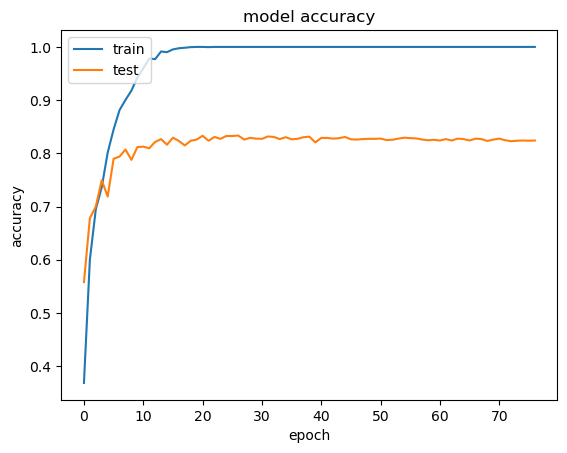

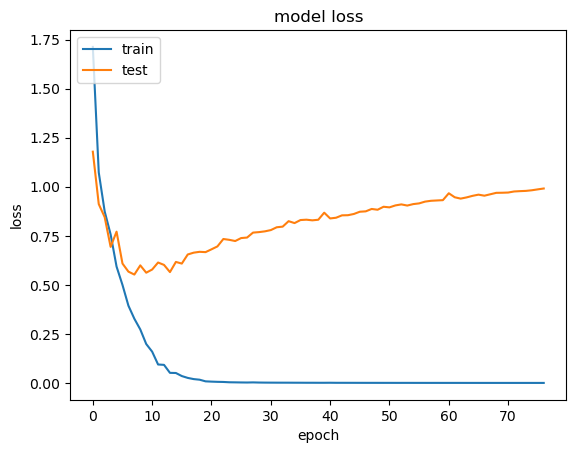

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
validation_steps = 20

loss0,accuracy0 = model.evaluate(xtest,ytest, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 73ms/step - loss: 0.9912 - acc: 0.8241
loss: 0.99
accuracy: 0.82


In [13]:
ypred = model.predict(xtest)

 2/71 [..............................] - ETA: 3s 

2023-01-07 19:23:37.580143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 4s 53ms/step


In [14]:
y_pred=np.argmax(ypred,axis=1)
y_test=np.argmax(ytest,axis=1)
print(y_pred.shape,y_test.shape)

(2251,) (2251,)


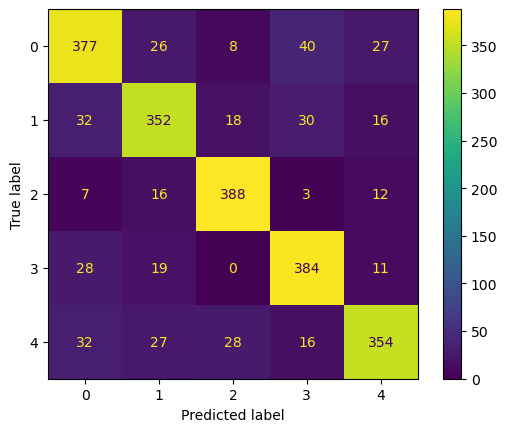

In [15]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay  
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix )
disp.plot()
plt.show()

#dict = {'ange':0,'clown':1,'goldfish':2,'lion':3,'scalaire':4}


In [16]:
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(5251, 100, 100, 3) (5251, 5) (2251, 100, 100, 3) (2251, 5)


In [27]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(100, 100, 3))




In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [29]:
conv_base.trainable=False
layerFlatten = (layers.Flatten())

layer1 = (layers.Dense(64, activation='relu')) 
prediction_layer = layers.Dense(len(dict),activation='softmax')
model = keras.Sequential([
  conv_base,
  layerFlatten,
  layer1,
  prediction_layer
])

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                294976    
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 15,009,989
Trainable params: 295,301
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

es = EarlyStopping(monitor='val_acc', patience=25)
history = model.fit(xtrain,ytrain,batch_size=126,epochs=100,steps_per_epoch=5,validation_steps=5,
                    validation_data=(xtest,ytest),callbacks=es)

Epoch 1/100


2023-01-07 19:38:17.982295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 1.5173 - acc: 0.3429

2023-01-07 19:38:21.815958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 7s 1s/step - loss: 1.5173 - acc: 0.3429 - val_loss: 1.0331 - val_acc: 0.6032
Epoch 2/100
5/5 [==============================] - 6s 1s/step - loss: 0.8650 - acc: 0.7079 - val_loss: 0.6343 - val_acc: 0.8048
Epoch 3/100
5/5 [==============================] - 5s 1s/step - loss: 0.5875 - acc: 0.8063 - val_loss: 0.4415 - val_acc: 0.8524
Epoch 4/100
5/5 [==============================] - 5s 1s/step - loss: 0.3759 - acc: 0.8746 - val_loss: 0.3767 - val_acc: 0.8651
Epoch 5/100
5/5 [==============================] - 5s 1s/step - loss: 0.3598 - acc: 0.8857 - val_loss: 0.3268 - val_acc: 0.8873
Epoch 6/100
5/5 [==============================] - 5s 1s/step - loss: 0.3517 - acc: 0.8746 - val_loss: 0.2786 - val_acc: 0.9079
Epoch 7/100
5/5 [==============================] - 5s 1s/step - loss: 0.3018 - acc: 0.9048 - val_loss: 0.2456 - val_acc: 0.9095
Epoch 8/100
5/5 [==============================] - 6s 1s/step - loss: 0.2734 - acc: 0.9095 - val_loss: 0.2361 - val_

In [32]:
validation_steps = 20

loss0,accuracy0 = model.evaluate(xtest,ytest, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 12s 604ms/step - loss: 0.1047 - acc: 0.9662
loss: 0.10
accuracy: 0.97


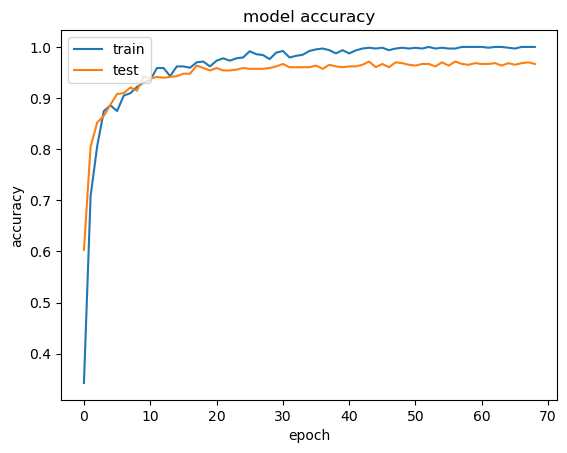

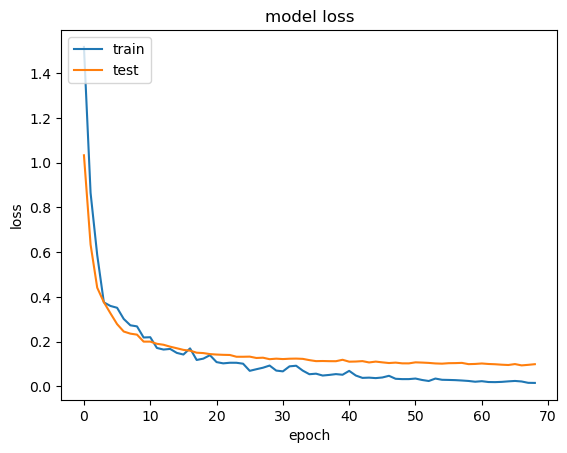

In [33]:


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
ypred = model.predict(xtest)

2023-01-07 19:45:08.146932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 10s 140ms/step


In [35]:
y_pred=np.argmax(ypred,axis=1)
#y_test=np.argmax(ytest,axis=1)
print(y_pred.shape,y_test.shape)

(2251,) (2251,)


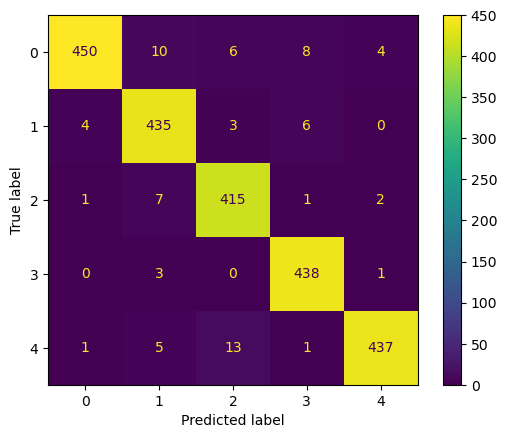

In [36]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay  
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix )
disp.plot()
plt.show()

#dict = {'ange':0,'clown':1,'goldfish':2,'lion':3,'scalaire':4}